In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [185]:
dataset_path = '/Users/gwynethang/Downloads/terrorism_new.csv'
dataset = pd.read_csv(dataset_path)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [186]:
#put the thing that you want to predict to the rightmost column -- gname
dataset = dataset.loc[:,['country','region','latitude','longitude','attacktype1',
                         'weaptype1','targtype1','nkill','success','gname']]

In [187]:
#remove Unknown terrorist groups
dataset = dataset[dataset['gname'] != "Unknown"]

In [188]:
#make a dictionary to map each gname to a number
name_map = {}
unique_gname = dataset['gname'].unique()
for i in range(len(unique_gname)):
    name_map[unique_gname[i]] = i

In [189]:
#replace gname with assigned number and drop rows with NaN values
dataset = dataset.replace({"gname":name_map})
dataset = dataset.dropna()

In [190]:
#attack counts per group
group_attack_count = {}
for i in dataset['gname']:
    if i in group_attack_count:
        group_attack_count[i] = 1 + group_attack_count[i]
    else:
        group_attack_count[i] = 1

In [191]:
len(group_attack_count)

3436

In [192]:
#list to determine which rows to discard later on (if in this list, gname has <500 attacks)
to_discard = []
for i in group_attack_count:
    if group_attack_count[i] < 500:
        to_discard.append(i)

In [193]:
#map that contains gnames and their attack counts (must have >= 500 attacks)
#this map is not used in model building, but is useful to see spread of attacks across gnames we are interested in
to_keep_map = {}
for i in group_attack_count:
    if group_attack_count[i] >= 500:
        to_keep_map[i] = group_attack_count[i]

In [194]:
len(to_keep_map)

31

In [195]:
#trim dataset to only include gnames we are interested in, we are not interested in gnames that are in to_discard
dataset = dataset[~dataset['gname'].isin(to_discard)]

## using accuracy as a metric

In [196]:
from sklearn.preprocessing import label_binarize
X = dataset.drop('gname', axis = 1)
Y = dataset['gname']
# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [197]:
# Instantiate model with 1000 decision trees
forest_classifier = RandomForestClassifier(n_estimators = 100)
# Train the model on training data
forest_classifier.fit(X_train, y_train);

In [198]:
forest_classifier.score(X_test, y_test)

0.9289085369496386

## label_binarize Y to get precision recall

In [199]:
from sklearn.preprocessing import label_binarize
X = dataset.drop('gname', axis = 1)
Y = label_binarize(dataset['gname'], classes=np.arange(31))
n_classes = Y.shape[1]

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [201]:
# Instantiate model with 1000 decision trees
forest_classifier = RandomForestClassifier(n_estimators = 100)
# Train the model on training data
forest_classifier.fit(X_train, y_train);

In [202]:
forest_classifier.score(X_test, y_test)

0.9986857040444471

In [203]:
y_score = forest_classifier.predict(X_test)

In [204]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.97


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.97')

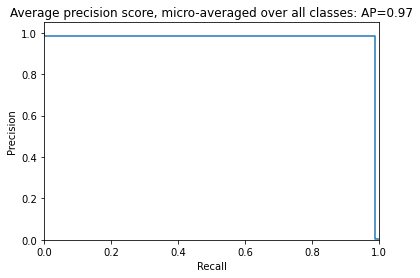

In [205]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))